In [45]:
import numpy as np
import pygam
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import itertools
import scipy as sp
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster
import pandas as pd
import seaborn as sb
import pygraphviz
plt.style.use('default')

import sys
sys.path.append("../../scripts/")
import visutil

In [46]:
FIG_DIR = "./"
DATA_DIR = "../../examples/ery/"
try:
    my_purple = matplotlib.colors.LinearSegmentedColormap.from_list("MyPurple", ['purple', 'purple', ])
    matplotlib.colormaps.register(cmap = my_purple)
    my_red = matplotlib.colors.LinearSegmentedColormap.from_list("MyRed", ['red', 'red', ])
    matplotlib.colormaps.register(cmap = my_red)
    my_grey = matplotlib.colors.LinearSegmentedColormap.from_list("MyGrey", ['#595959', '#595959', ])
    matplotlib.colormaps.register(cmap = my_grey)
except:
    pass

In [64]:
adata = ad.read_h5ad("anndata.h5ad")
adata = adata[:, adata.var.istf]
G = np.load("TE_full.npy")
adata.uns["G"] = np.swapaxes(G.reshape(-1, adata.shape[1], adata.shape[1]), 1, 2).reshape(-1, adata.shape[1]**2) # fix Julia orientation

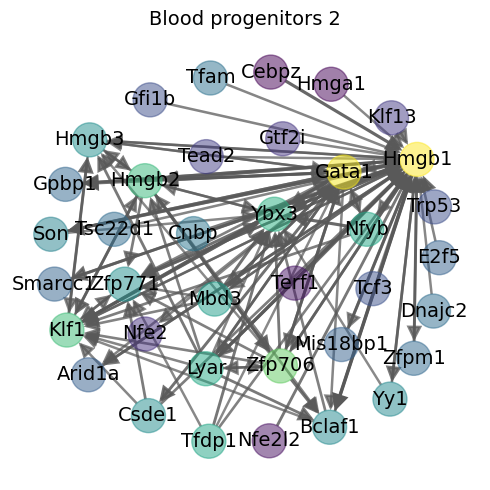

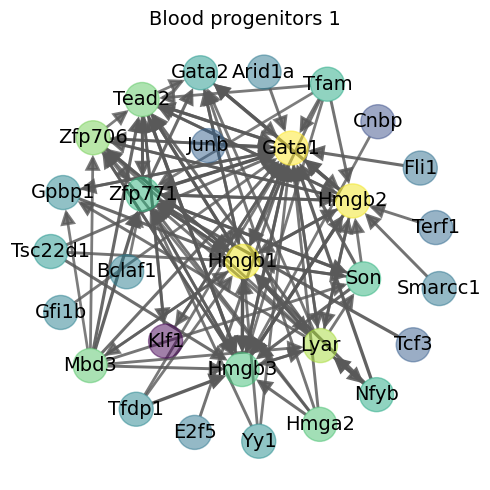

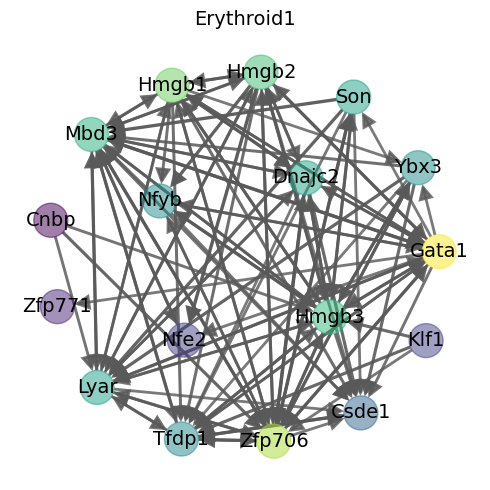

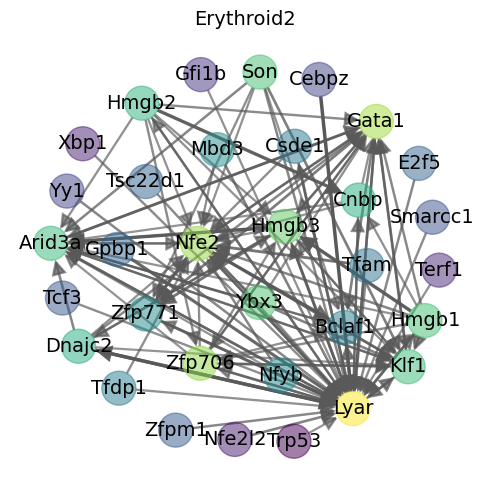

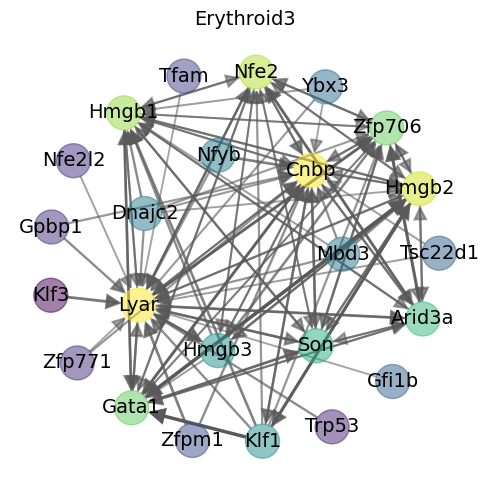

In [66]:
for k in pd.unique(adata.obs.celltype):
    A = adata.uns["G"][adata.obs.celltype == k, :].mean(0).reshape(adata.shape[1], adata.shape[1])
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
    # nx.set_edge_attributes(g, {(i, j) : J_beta_net_closure[i, j] for (i, j) in g.edges}, name = "ref")
    nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
    plt.figure(figsize = (5, 5))
    visutil.draw(g, adata.var.index, thresh = 0.995, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
    plt.gca().axis("off")
    plt.title(k, fontsize = 14)
    plt.tight_layout()
    plt.savefig(FIG_DIR + "eryth_cluster_avg_network_%s_filtered.pdf" % k)

(-10.56434500000001, 426.59534500000007, -19.05872, 411.29472)

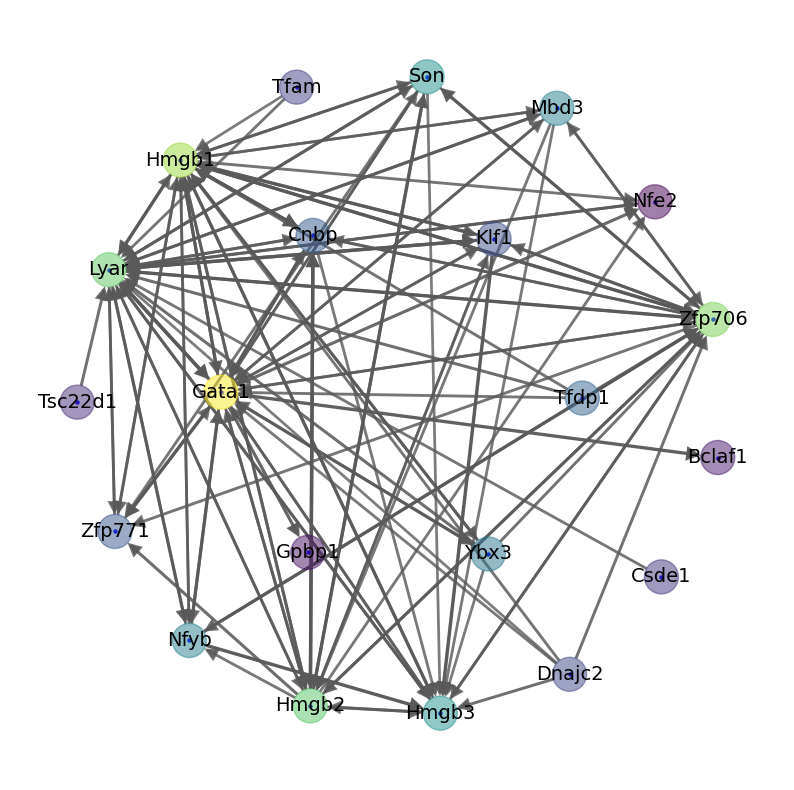

In [79]:
g = nx.DiGraph(np.mean(adata.uns["G"][adata.obs.velocity_pseudotime < 0.9, :], axis = 0).reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
# get weights from g
edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
weights = np.array(list(weights))
weights /= np.max(weights)
# node and edgelist
nl = list(g.nodes())
el = list(g.edges())
edge_idx = np.where(weights > np.quantile(weights, 0.995))[0]
edgelist = [el[i] for i in edge_idx]

node_idx = list(set(itertools.chain(*edgelist)))
nodelist = [nl[i] for i in node_idx]
# take subgraph
g_sub = g.subgraph(nodelist)

# now plot
edges,weights = zip(*nx.get_edge_attributes(g_sub,'weight').items())
weights = np.array(list(weights))
weights /= np.quantile(weights, 0.999)
weights = np.minimum(1, weights)
edge_idx2 = np.where([e in edgelist for e in g_sub.edges()])[0]

fig = plt.figure(figsize = (10, 10))
# pos = nx.shell_layout(g_sub)
# pos = nx.spring_layout(g_sub, iterations = 250, seed = 0)
pos = nx.nx_agraph.graphviz_layout(g_sub, prog = 'fdp')
nx.draw_networkx_nodes(g_sub, pos, node_color = "b", node_size = 5)
arrows = nx.draw_networkx_edges(g_sub, pos, edgelist = edgelist, edge_color = weights[edge_idx2], alpha = weights[edge_idx2], width = 2.5*weights[edge_idx2], edge_cmap = matplotlib.colormaps["MyGrey"], edge_vmin = 0.1, node_size = 600)
for a, w in zip(arrows, weights):
    # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
    a.set_mutation_scale(16 + w)
    a.set_joinstyle('miter')
    a.set_capstyle('butt')
nx.draw_networkx_labels(g_sub, pos, labels = {i : adata.var.index[i] for i in g_sub.nodes()}, font_size = 14);
nodes, centrality = zip(*nx.get_node_attributes(g_sub,'centrality').items())
centrality /= np.max(centrality)
nx.draw_networkx_nodes(g, pos, nodelist = nodes, node_color = centrality, cmap = matplotlib.colormaps["viridis"], alpha = 0.5, node_size = 600)
plt.axis("off")

In [80]:
G_tensor = adata.uns["G"].reshape(-1, adata.shape[1], adata.shape[1])
G_subset = np.vstack([G_tensor[:, i, j] for (i, j) in edgelist])

In [81]:
import seaborn as sb
gams = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.velocity_pseudotime, x) for x in G_subset]
G_gam = np.vstack([g.predict(adata.obs.velocity_pseudotime) for g in gams])
row_perm = np.argsort(np.median(G_gam * np.array(adata.obs.velocity_pseudotime).reshape(1, -1), -1))

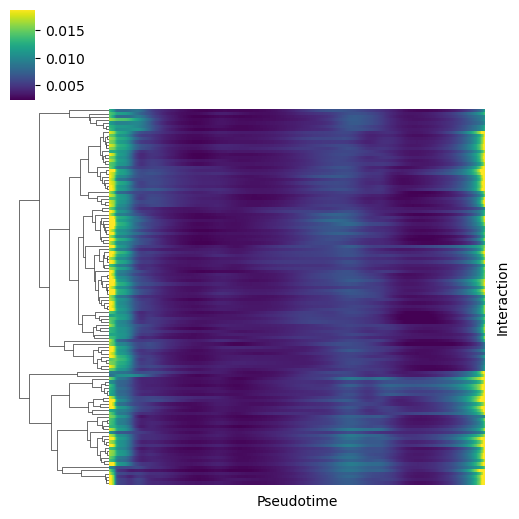

In [82]:
import scipy
cg = sb.clustermap(G_gam[:, np.argsort(adata.obs.velocity_pseudotime)][row_perm, :], 
                   row_cluster = True, col_cluster = False, metric = "correlation",
                   xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", rasterized = True,
                   vmin = np.quantile(G_gam, 0.005), vmax = np.quantile(G_gam, 0.995))
cg.ax_heatmap.set_xlabel("Pseudotime")
cg.ax_heatmap.set_ylabel("Interaction")
cg.savefig(FIG_DIR + "eryth_interactions_clustermap.pdf")

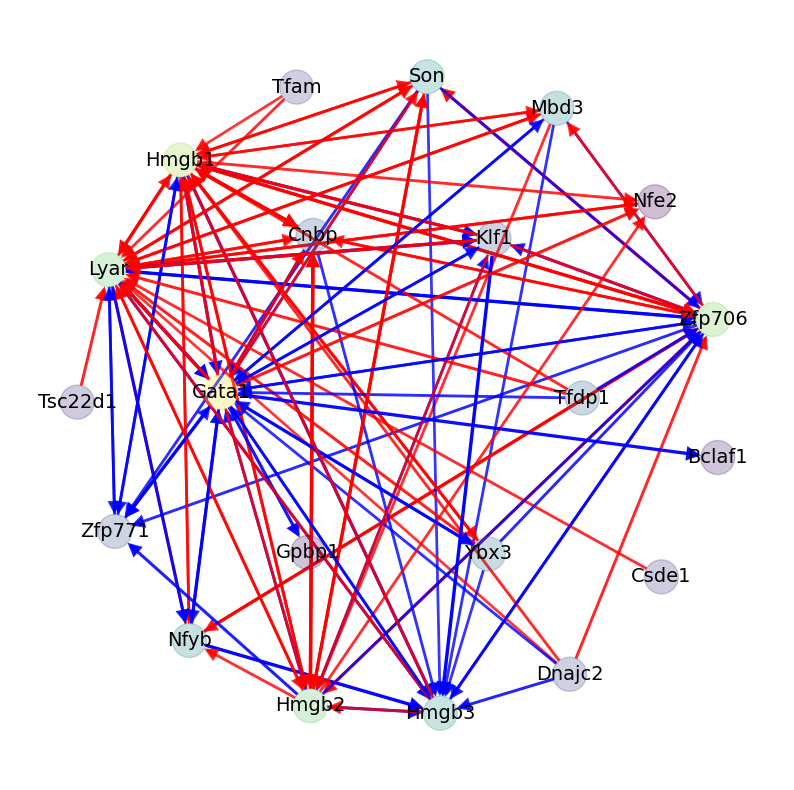

In [83]:
active_dpt = np.array(adata.obs.velocity_pseudotime)[np.argsort(G_gam, -1)[:, -1]]
blue_red1 = matplotlib.colors.LinearSegmentedColormap.from_list("BlueRed1", ['blue', 'red'])
fig = plt.figure(figsize = (10, 10))
arrows = nx.draw_networkx_edges(g_sub, pos, edgelist = edgelist, edge_color = active_dpt, alpha = weights[edge_idx2], width = 2.5*weights[edge_idx2], edge_cmap = blue_red1, node_size = 600)
for a, w in zip(arrows, weights):
    # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
    a.set_mutation_scale(16 + w)
    a.set_joinstyle('miter')
    a.set_capstyle('butt')
nx.draw_networkx_labels(g_sub, pos, labels = {i : adata.var.index[i] for i in g_sub.nodes()}, font_size = 14);
nx.draw_networkx_nodes(g, pos, nodelist = nodes, node_color = centrality, cmap = matplotlib.colormaps["viridis"], alpha = 0.25, node_size = 600)
plt.axis("off")
plt.savefig(FIG_DIR + "eryth_interactions_color_network.pdf")

In [84]:
def top_correlates(fates, Gs):
    G_corrs = np.array([((1+sp.stats.pearsonr(fates,g)[0])/2)*np.mean(g) for g in Gs.T])
    # G_corrs = np.array([np.dot(fates, g) for g in Gs.T])
    G_corrs[np.isnan(G_corrs)] = 0
    return G_corrs

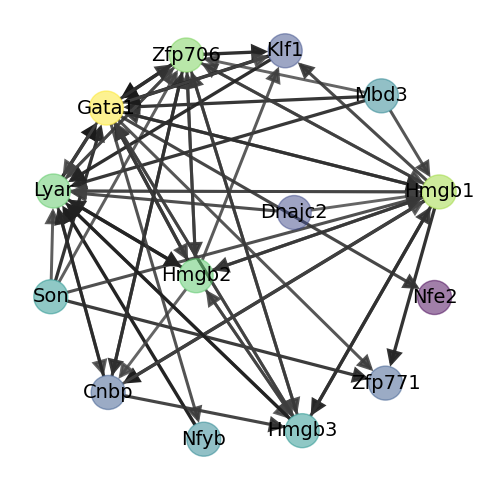

In [85]:
A = np.mean(adata.uns["G"][adata.obs.velocity_pseudotime < np.quantile(adata.obs.velocity_pseudotime, 0.9), :], axis = 0).reshape(adata.shape[1], adata.shape[1])
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 1_000), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
fig = plt.figure(figsize = (5, 5))
visutil.draw(g, adata.var.index, thresh = 0.9975, cmap_dict = {0 : "Greys", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=2")
plt.axis("off")
plt.tight_layout()
plt.savefig(FIG_DIR + "eryth_static_network.pdf")

In [86]:
import sklearn as sk
from sklearn import manifold
G_pca = sk.decomposition.PCA(n_components = 10).fit_transform(adata.uns["G"])

In [87]:
G_spec = sk.manifold.SpectralEmbedding(n_components = 5).fit_transform(G_pca)

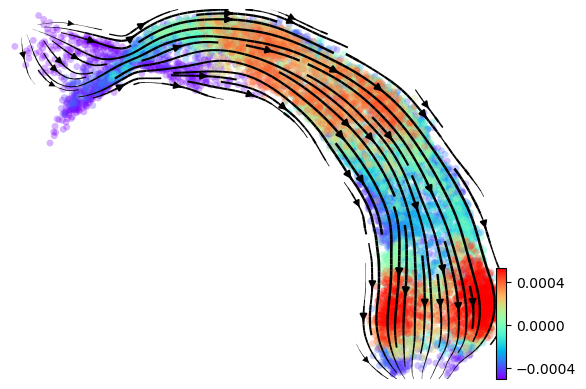

In [88]:
import scvelo as scv
scv.pl.velocity_embedding_stream(adata, color=G_spec[:, 0], dpi=100, title='', cmap = "rainbow")

In [ ]:
sp.sparse.csr_matrix(adata.uns["G"], dtype = np.float32)

In [ ]:
sc.pl.scatter(adata, basis = "umap", color = "Gata2")
sc.pl.scatter(adata, basis = "umap", color = "Spi1")
sc.pl.scatter(adata, basis = "umap", color = "Gata1")